In [1]:
import numpy as np
import pandas as pd
import scipy.sparse, scipy.stats, scipy.optimize
import matplotlib.pyplot as plt
import collections

def sparse_arrays_to_sparse_matrix(dfs):
    '''
    Converts a binary DataFrame with SparseArray columns into a
    scipy.sparse.coo_matrix.
    '''
    positions = []
    fill_values = []
    for i in range(dfs.shape[1]):
        col_entries = dfs.iloc[:,i].values
        col_num_entries = col_entries.sp_index.npoints
        col_positions = np.empty((2,col_num_entries), dtype='int')
        col_positions[0,:] = col_entries.sp_index.indices
        col_positions[1,:] = i
        col_fill_values = col_entries.sp_values
        positions.append(col_positions)
        fill_values.append(col_fill_values)
    positions = np.concatenate(positions, axis=1)
    fill_values = np.concatenate(fill_values)
    spdata = scipy.sparse.coo_matrix((fill_values, positions), shape=dfs.shape)
    return spdata


def estimate_pan_core_size(df_genes, num_iter=10, log_batch=1):
    '''
    Computes pan/core genome size curves for many randomizations
    '''
    num_genes, num_strains = df_genes.shape
    gene_data = sparse_arrays_to_sparse_matrix(df_genes)
    gene_data = gene_data.T.tocsr() # now strain x cluster
    pan_genomes = np.zeros((num_iter, num_strains)) # estimated pan-genome curve per iteration
    core_genomes = np.zeros((num_iter, num_strains)) # estimated core-genome curve per iteration

    ''' Simulate pan/core-genomes for randomly ordered strains '''
    for i in range(num_iter):
        if (i+1) % log_batch == 0:
            print('Iteration', i+1, 'of', num_iter)
        shuffle_indices = np.arange(num_strains)
        np.random.shuffle(shuffle_indices)
        gene_incidence = np.zeros(num_genes, dtype='int')
        for j,shuffle_col in enumerate(shuffle_indices):
            gene_incidence += gene_data[shuffle_col,:]
            pan_genomes[i,j] = (gene_incidence > 0).sum()
            core_genomes[i,j] = (gene_incidence == j+1).sum()

    ''' Save to DataFrame '''
    iter_index = list(map(lambda x: 'Iter' + str(x), range(1,num_iter+1)))
    pan_cols = list(map(lambda x: 'Pan' + str(x), range(1,num_strains+1)))
    core_cols = list(map(lambda x: 'Core' + str(x), range(1,num_strains+1)))
    df_pan_core = pd.DataFrame(index=iter_index, columns=pan_cols + core_cols,
                               data=np.hstack([pan_genomes, core_genomes]))
    return df_pan_core


def fit_heaps(df_freqs):
    ''' Fits a single iteration to Heaps Law: PG size = kappa * (genes)^alpha '''
    heaps = lambda x, alpha, kappa: kappa * np.power(x,alpha)
    n_strains = df_freqs.shape[0]
    p0 = [0.5, float(min(df_freqs.values))]
    popt, pcov = scipy.optimize.curve_fit(heaps, 
        np.arange(1,n_strains+1), df_freqs.values, p0=p0)
    return popt


def fit_heaps_by_iteration(df_pan_core):
    ''' Fits Heaps Law to each iteration and returns alpha and kappa for each iteration '''
    df = df_pan_core.iloc[:,:int(df_pan_core.shape[1]/2)].T
    n_samples, n_iters = df.shape
    heaps_fits = {}
    for i,iter_label in enumerate(df.columns):
        alpha, kappa = fit_heaps(df.iloc[:,i])
        heaps_fits[iter_label] = {'alpha':alpha, 'kappa':kappa}
    return pd.DataFrame.from_dict(heaps_fits, orient='index').reindex(df.columns)

Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration 4 of 20
Iteration 5 of 20
Iteration 6 of 20
Iteration 7 of 20
Iteration 8 of 20
Iteration 9 of 20
Iteration 10 of 20
Iteration 11 of 20
Iteration 12 of 20
Iteration 13 of 20
Iteration 14 of 20
Iteration 15 of 20
Iteration 16 of 20
Iteration 17 of 20
Iteration 18 of 20
Iteration 19 of 20
Iteration 20 of 20


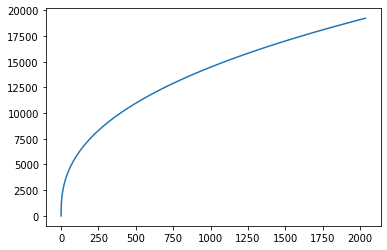

In [4]:
df_genes = pd.read_pickle('~/Desktop/project_cc8/trials/pangenomics/data/CC8_strain_by_gene.pickle.gz')
df_pan_core = estimate_pan_core_size(df_genes, num_iter=20, log_batch=1)
df_heap = fit_heaps_by_iteration(df_pan_core)

heaps = lambda x, alpha, kappa: kappa * np.power(x,alpha)

a, k = df_heap.loc['Iter20']

gene_fitted = [heaps(n, a, k) for n in np.arange(2037)]

plt.plot(gene_fitted)
# plt.scatter(strain_counter[::50], median_pan_genome[::50], label='Pan-genome')

Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration 4 of 20
Iteration 5 of 20
Iteration 6 of 20
Iteration 7 of 20
Iteration 8 of 20
Iteration 9 of 20
Iteration 10 of 20
Iteration 11 of 20
Iteration 12 of 20
Iteration 13 of 20
Iteration 14 of 20
Iteration 15 of 20
Iteration 16 of 20
Iteration 17 of 20
Iteration 18 of 20
Iteration 19 of 20
Iteration 20 of 20


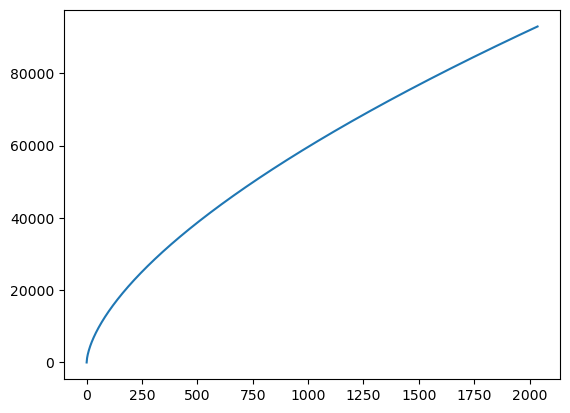

In [10]:
df_genes = pd.read_pickle('data/CC8_strain_by_allele.pickle.gz')
df_pan_core = estimate_pan_core_size(df_genes, num_iter=20, log_batch=1)
df_heap = fit_heaps_by_iteration(df_pan_core)

heaps = lambda x, alpha, kappa: kappa * np.power(x,alpha)

a, k = df_heap.loc['Iter20']

orf_fitted = [heaps(n, a, k) for n in np.arange(2037)]

plt.plot(orf_fitted)
# plt.scatter(strain_counter[::50], median_pan_genome[::50], label='Pan-genome')

Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration 4 of 20
Iteration 5 of 20
Iteration 6 of 20
Iteration 7 of 20
Iteration 8 of 20
Iteration 9 of 20
Iteration 10 of 20
Iteration 11 of 20
Iteration 12 of 20
Iteration 13 of 20
Iteration 14 of 20
Iteration 15 of 20
Iteration 16 of 20
Iteration 17 of 20
Iteration 18 of 20
Iteration 19 of 20
Iteration 20 of 20


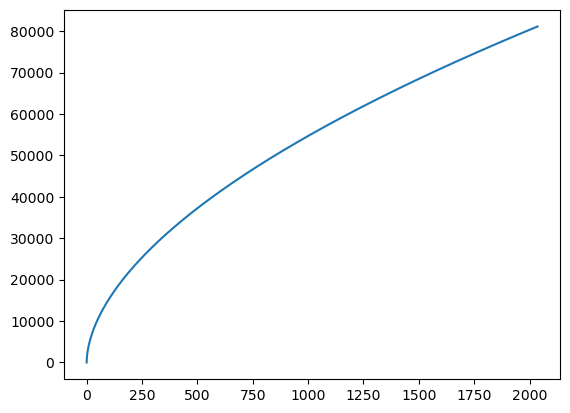

In [11]:
df_genes = pd.read_pickle('data/CC8_strain_by_upstream.pickle.gz')
df_pan_core = estimate_pan_core_size(df_genes, num_iter=20, log_batch=1)
df_heap = fit_heaps_by_iteration(df_pan_core)

heaps = lambda x, alpha, kappa: kappa * np.power(x,alpha)

a, k = df_heap.loc['Iter20']

up_fitted = [heaps(n, a, k) for n in np.arange(2037)]

plt.plot(up_fitted)
# plt.scatter(strain_counter[::50], median_pan_genome[::50], label='Pan-genome')

Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration 4 of 20
Iteration 5 of 20
Iteration 6 of 20
Iteration 7 of 20
Iteration 8 of 20
Iteration 9 of 20
Iteration 10 of 20
Iteration 11 of 20
Iteration 12 of 20
Iteration 13 of 20
Iteration 14 of 20
Iteration 15 of 20
Iteration 16 of 20
Iteration 17 of 20
Iteration 18 of 20
Iteration 19 of 20
Iteration 20 of 20


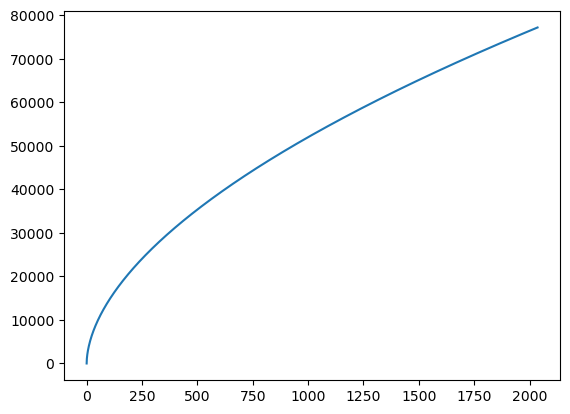

In [12]:
df_genes = pd.read_pickle('/home/saugat/Desktop/project_cc8/trials/pangenomics/data/CC8_strain_by_downstream.pickle.gz')
df_pan_core = estimate_pan_core_size(df_genes, num_iter=20, log_batch=1)
df_heap = fit_heaps_by_iteration(df_pan_core)

heaps = lambda x, alpha, kappa: kappa * np.power(x,alpha)

a, k = df_heap.loc['Iter20']

down_fitted = [heaps(n, a, k) for n in np.arange(2037)]

plt.plot(down_fitted)
# plt.scatter(strain_counter[::50], median_pan_genome[::50], label='Pan-genome')

In [15]:
# set matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14
label_font = {'fontsize': 18}
text_font = {'fontsize': 12}
text_font_small = {'fontsize': 10}
tick_font = {'fontsize': 16}

/home/saugat/anaconda3/envs/ete3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/home/saugat/anaconda3/envs/ete3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


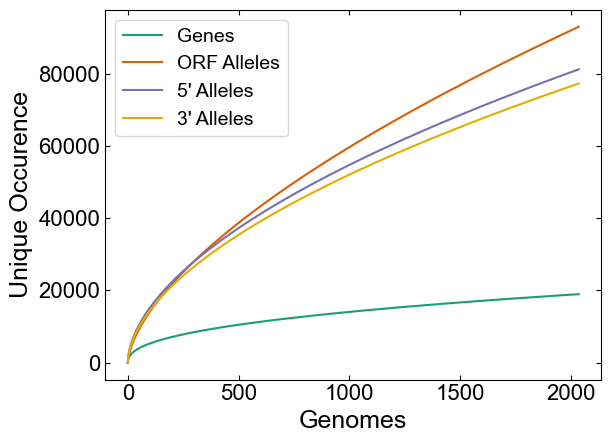

In [28]:
fig, ax = plt.subplots()

ax.plot(gene_fitted, label='Genes', color='#1b9e77')
ax.plot(orf_fitted, label='ORF Alleles', color='#d95f02')
ax.plot(up_fitted, label='5\' Alleles', color='#7570b3')
ax.plot(down_fitted, label='3\' Alleles', color='#e6ab02')


ax.set_ylabel('Unique Occurence',  **label_font)
ax.set_xlabel('Genomes',  **label_font)

ax.tick_params(which='both', axis='both', direction='in', reset=True)
ax.set_yticklabels(np.arange(-20_000, 100_000, 20_000), fontsize=tick_font['fontsize'])
ax.set_xticklabels(np.arange(-500, 2500, 500), fontsize=tick_font['fontsize'])

# ax.set_yscale('log')
plt.legend()

plt.savefig('figures/Gene_allele_occurence.svg')

Text(0, 0.5, 'Gene/Mutation Occurence')

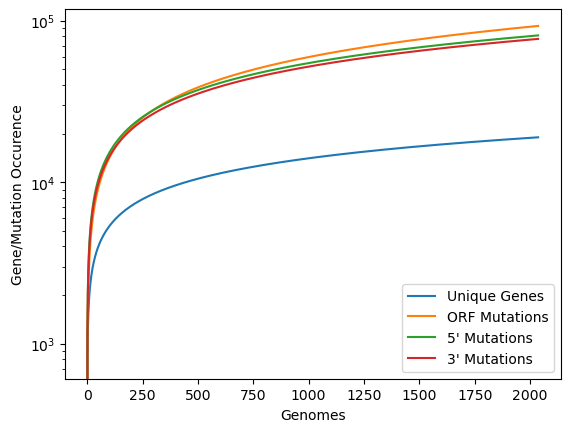

In [14]:
plt.plot(gene_fitted, label='Unique Genes')
plt.plot(orf_fitted, label='ORF Mutations')

plt.plot(up_fitted, label='5\' Mutations')
plt.plot(down_fitted, label='3\' Mutations')

plt.legend()
plt.yscale('log')

plt.xlabel('Genomes')
plt.ylabel('Gene/Mutation Occurence')

In [17]:
def estimate_segment_curves(df_genes, df_mlst=None, steps=20, threshold=0.1, iterations=10, min_genomes=20):
    '''
    Randomly shuffles genome order and computes the size of the pan,
    core, accessory, and unique genomes as genomes are introduced 
    sequentially. Pan-genome size is computed for everything genome,
    core/accessory/unique genome sizes are computed for a fixed number
    of steps.
    
    Parameters
    ----------
    df_genes : pd.DataFrame
        Binary gene x strain table
    df_mlst : pd.DataFrame
        Organisms-specific compiled MLST table. If provided, shuffles 
        LST types and picks 1 genomes per type per iteration instead 
        (default None)
    steps : int
        Number of equally spaced genome counts at which to 
        compute core/accessory/unique genome sizes. If -1, uses
        maximum number of steps (default 20)
    threshold : float
        Proximity to each frequency extreme compared to inflection point
        that determines if a gene is core, unique, or accessory. Same
        as what is provided to find_pangenome_segments() (default 0.1) 
    iterations : int
        Number of random genome order shuffles to generate (default 10)
    min_genomes : int
        Minimum number of genomes to attempt segmentation (default 20)
        
    Returns
    -------
    pg_curves : np.ndarray
        (iterations x n_genomes) array with the size of the pangenome as 
        each genome is sequentially introduced within each genome shuffle.
        pg_curves[i,j] = pan-genome size at j genomes in interation i
    segment_curves : np.ndarray
        (3 x iterations x steps) array with the size of the core,
        accessory, and unique genomes as each genome is sequentially
        introduced within in each genome shuffle, computed at steps.
        segment_curves[0,i,j] = core genome size at j step in iteration i
    inflection_points : np.ndarray
        (iteration x steps) array with the frequency inflection point
        as each genome is sequentially introduced within each genome 
        shuffle, computed at steps.
    genome_limits : np.ndarray
        Genomes introduced at each step of computing core, accessory, and
        unique genome sizes.
    '''
    if type(df_genes) == pd.DataFrame: # use values array from dataframe
        gene_data = df_genes.fillna(0).values
    else: # use raw numpy array
        gene_data = df_genes
    
    ''' Initialize output wrt mlst data, genome/mlst counts, and step size '''
    if not df_mlst is None:
        unique_mlsts = df_mlst.mlst.unique()
        n_mlsts = len(unique_mlsts)
    n_genes, n_genomes = gene_data.shape
    n_samples = n_genomes if df_mlst is None else n_mlsts
    starting_genomes = max(n_samples/steps, min_genomes)
    
    pg_curves = np.zeros(shape=(iterations, n_samples)) # iteration x running pangenome size
    if steps > 0:
        genome_limits = np.linspace(starting_genomes, n_samples, steps, dtype=int)
    else:
        genome_limits = np.arange(starting_genomes, n_samples+1) # genomes per step for segmenting
    n_steps = len(genome_limits)
    segment_curves = np.zeros(shape=(3, iterations, n_steps)) # (core,acc,unique) x iteration x running size
    inflection_points = np.zeros(shape=(iterations, n_steps)) # iteration x running frequency inflection point

    ''' Generate random shufflings -> pan-genome curves iterations '''
    for i in range(iterations):
        print('Iteration', i+1)
        if df_mlst is None: # genome order shuffling
            genome_order = np.arange(n_genomes)
            np.random.shuffle(genome_order)
            gene_data_shuffled = gene_data[:,genome_order] # reorder genomes in full gene table
        else: # MLST based shuffling
            np.random.shuffle(unique_mlsts)
            mlst_representative_genomes = []
            for mlst in unique_mlsts:
                df_mlst_specific = df_mlst[df_mlst.mlst == mlst]
                if df_mlst_specific.shape[0] == 1:
                    mlst_representative_genomes.append(df_mlst_specific.index[0])
                else:
                    selected = np.random.randint(0,df_mlst_specific.shape[0])
                    mlst_representative_genomes.append(df_mlst_specific.index[selected])
            df_mlst_genes = df_genes.loc[:,mlst_representative_genomes]
            gene_data_shuffled = df_mlst_genes.fillna(0).values
        
        ''' Computing pan-genome curve '''
        freqs = collections.Counter(np.argmax(gene_data_shuffled, axis=1))
        freqs_ordered = [freqs[x] if x in freqs else 0 for x in np.arange(n_samples)]
        missing_genes = (gene_data_shuffled.sum(axis=1) == 0).sum()
        pg_curves[i,:] = np.cumsum(freqs_ordered) - missing_genes
    
        ''' Segmenting into core/accessory/unique genomes '''
        for g,genome_limit in enumerate(genome_limits):
            ''' Fitting inflection point '''
            subset_data = gene_data_shuffled[:, :genome_limit]
            segments, popt, r2, mae = find_pangenome_segments(subset_data, threshold=threshold, ax=None) 
            segments = np.array(segments)
            inflection_freq = segments[1] / threshold

            ''' Computing core, accessory, unique genome sizes '''
            subset_counts = subset_data.sum(axis=1)
            missing_genes = (subset_counts == 0).sum()
            subset_size = n_genes - missing_genes
            inflection_points[i,g] = inflection_freq
            segment_curves[0,i,g] = (subset_counts > segments[0]).sum() # core
            segment_curves[2,i,g] = (subset_counts < segments[1]).sum() - missing_genes # unique
            segment_curves[1,i,g] = subset_size - segment_curves[0,i,g] - segment_curves[2,i,g] # accessory
    return pg_curves, segment_curves, inflection_points, genome_limits

def find_pangenome_segments(df_genes, threshold=0.1, ax=None):
    '''
    Computes the gene frequency thresholds at which a gene can be categorized as 
    core, accessory, or unique. Specifically, models the gene frequency distribution
    as the sum of two power laws (one flipped), and fits the CDF to a five-parameter
    function dervied from those power laws. Also identifies the inflection point and
    the core and unique extremes relative to the inflection point and threshold.
    
          PMF(x;c1,c2,a1,a2) ~ c1 * x^-a1 + c2 * (n-x)^-a2
        CDF(x;c1,c2,a1,a2,k) ~ c1/(1-a1) * x^(1-a1) - c2/(1-a2) * (n-x)^(1-a2) + k
        
    Where x = frequency, n = maximum frequency + 1, other variables are parameters.
    
    Pangenome segments example at 10%:
    - N = total strains, R = computed inflection point
    - Core: Observed in >= R + (1 - 0.1) * (N-R) strains
    - Unique: Observed in <= 0.1 * R strains
    - Accessory: Everything in between
    
    Parameters
    ----------
    df_genes : pd.DataFrame
        Binary gene x strain table.
    threshold : float
        Proximity to each frequency extreme compared to inflection point
        that determines if a gene is core, unique, or accessory (default 0.1)
    ax : plt.axes
        If provided, plots pangenome frequency CDF with segments (default None)
        
    Returns
    -------
    segments : tuple
        2-tuple with (min core limit, max unique limit), not rounded.
    popt : tuple
        5-tuple with fitted CDF parameters (c1,c2,a1,a2,k). Note that
        c1, c2, and k are scaled relative to the number of unique genes
    r_squared : float
        R^2 between fit and observed cumulative gene frequency distribution
    ax : plt.axes
        If ax is not None, returns axis with plots
    '''

    ''' Computing gene frequencies and frequency counts '''
    if type(df_genes) == pd.DataFrame: # data frame provided
        df_gene_freq = df_genes.fillna(0).sum(axis=1)
    else: # array provided
        df_gene_freq = pd.Series(data=df_genes.sum(axis=1), 
                                 index=list(map(lambda x: 'G' + str(x), range(df_genes.shape[0]))))
    df_freq_counts = df_gene_freq.value_counts()
    if 0 in df_freq_counts.index: # filter out unobserved genes (i.e. when subsetting genomes)
        df_freq_counts.drop(index=0, inplace=True)
    df_freq_counts = df_freq_counts[sorted(df_freq_counts.index)]
    cumulative_frequencies = np.cumsum(df_freq_counts.values)
    frequency_bins = np.array(df_freq_counts.index)
    
    ''' Fitting CDF '''
    X = frequency_bins.astype(float)
    Y = cumulative_frequencies.astype(float)
    n = max(frequency_bins) + 1
    dual_power_cdf = lambda x,c1,c2,a1,a2,k: \
        Y[0]*(c1*np.power(x,1.0-a1)/(1.0-a1) - c2*np.power(n-x,1.0-a2)/(1.0-a2) + k)
    p0 = [1.0,1.0,2.0,2.0,1.0]
    bounds = ([0.0,0.0,1.0,1.0,0.0],[np.inf,np.inf,np.inf,np.inf,Y[-1]/Y[0]])
    popt, pcov = scipy.optimize.curve_fit(dual_power_cdf, X, Y, p0=p0, bounds=bounds, maxfev=100000)
    
    ''' Extracting inflection point of CDF and frequency thresholds '''
    dual_power_pdf = lambda x,c1,c2,a1,a2: Y[0]*(c1*np.power(x,-a1) + c2*np.power(n-x,-a2))
    dual_power_pdf_fit = lambda x: dual_power_pdf(x,*popt[:4]) # minimize PMF
    res = scipy.optimize.minimize_scalar(dual_power_pdf_fit, method='bounded', bounds=[1,n-1])
    inflection_freq = res.x # inflection point x, i.e. frequency threshold 
    unique_strains_max = inflection_freq * threshold
    core_strains_min = inflection_freq + (n - 1 - inflection_freq) * (1.0 - threshold)
    segments = (core_strains_min, unique_strains_max)
    
    ''' Curve fit evaluation: R^2 and MAE
        R^2 technically invalid for nonlinear fits but commonly reported
        MAE is more relevant for judging nonlinear models '''
    Yfit = np.array(list(map(lambda x: dual_power_cdf(x,*popt), X))) # fitted CDF
    SStot = np.sum(np.square(Y - Y.mean()))
    SSres = np.sum(np.square(Y - Yfit))
    r_squared = 1 - (SSres/SStot)
    # rmse = np.sqrt(np.square(Y - Yfit).mean())
    mae = np.abs(Y - Yfit).mean()
    
    ''' Optionally, generating plot '''

    if ax:
        ax.plot(X, Y, label='observed', color='#e41a1c')
        ax.plot(X, Yfit, label='fit', ls='--',  color='#377eb8')
        ax.scatter([inflection_freq], [dual_power_cdf(inflection_freq,*popt)], 
                   label='inflection point', color='black', alpha=0.7)
        ax.axvline(unique_strains_max, ls='--', color='k')
        ax.axvline(core_strains_min, ls='--', color='k')
        ax.axvline(inflection_freq, ls='--', color='lightgray')
        
        unique_rounded = int(unique_strains_max) + 1
        core_rounded = int(core_strains_min)
        unique_text = 'Unique:\n<' + str(unique_rounded)
        core_text = 'Core:\n>' + str(core_rounded)
        r2_text = 'R^2=' + str(np.round(r_squared,3))
        mae_text = 'MAE=' + str(np.round(mae,2))
        ax.text(unique_strains_max + n*0.02, Y[0], unique_text, ha='left', va='bottom')
        ax.text(core_strains_min - n*0.02, Y[0], core_text, ha='right', va='bottom')
        ax.text(unique_strains_max + n*0.1, 0.95*Y[-1], r2_text, ha='left', va='bottom')
        ax.text(unique_strains_max + n*0.1, 0.95*Y[-1], mae_text, ha='left', va='top')
        ax.set_xlabel('Gene frequency')
        ax.set_ylabel('Cumulative genes')
        return segments, popt, r_squared, mae, ax
    else:
        return segments, popt, r_squared, mae


def find_pangenome_segments_logistic(df_genes, threshold=0.1, ax=None):
    '''
    Computes the gene frequency thresholds at which a gene can be categorized as 
    core, accessory, or unique. Specifically, fits a three-parameter logistic 
    function for cumulative genes vs. max strains with gene (gene frequency),
    identifies the inflection point, and identifies the core and unique extremes
    relative to the inflection point and threshold. See link for details,
    where parameters (B,v,M) are fit.
    
    https://en.wikipedia.org/wiki/Generalised_logistic_function
    
    Example at 10%:
    - N = total strains, R = computed inflection point
    - Core: Observed in >= R + (1 - 0.1) * (N-R) strains
    - Unique: Observed in <= 0.1 * R strains
    - Accessory: Everything in between
    
    Parameters
    ----------
    df_genes : pd.DataFrame
        Binary gene x strain table.
    threshold : float
        Proximity to each frequency extreme compared to inflection point
        that determines if a gene is core, unique, or accessory (default 0.1)
    ax : plt.axes
        If provided, pangenome frequency plot with segments (default None)
        
    Returns
    -------
    segments : tuple
        2-tuple with (min core limit, max unique limit), not rounded.
    popt : tuple
        3-tuple with fitted logistic parameters. These parameters are 
        fit after scaling the x and y to the range 0-1.
    ax : plt.axes
        If ax is not None, returns axis with plots.
    '''
    
    ''' Computing gene frequencies and frequency counts '''
    df_gene_freq = df_genes.fillna(0).sum(axis=1)
    df_freq_counts = df_gene_freq.value_counts()
    df_freq_counts = df_freq_counts[sorted(df_freq_counts.index)]
    cumulative_frequencies = np.cumsum(df_freq_counts.values)
    frequency_bins = df_freq_counts.index

    ''' Fitting 3-parameter logistic '''
    def generalized_logistic(t,B,v,M):
    #     return A + (K-A) * np.power(1.0+np.exp(-B*(t-M)), -1.0/v) # 5-parameter form
        return np.power(1.0+np.exp(-B*(t-M)), -1.0/v) # 3-parameter form

    X = cumulative_frequencies.astype(float)
    Y = frequency_bins.values.astype(float)
    Xscaled = (X - np.min(X)) / (np.max(X) - np.min(X))
    Yscaled = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
    p0 = [1.0, 1.0, 1.0]
    popt, pcov = scipy.optimize.curve_fit(generalized_logistic, Xscaled, Yscaled, p0)
    B,v,M = popt
    Yfit = np.array(list(map(lambda x: generalized_logistic(x, *popt), Xscaled)))
    Yfit = Yfit * (np.max(Y) - np.min(Y)) + np.min(Y)
    
    ''' Segmenting into core/accessory/unique '''
    inflection_scaled_x = M - np.log(v) / B
    inflection_scaled_y = generalized_logistic(inflection_scaled_x, *popt)
    inflection_genes = inflection_scaled_x * (np.max(X) - np.min(X)) + np.min(X)
    inflection_strains = inflection_scaled_y * (np.max(Y) - np.min(Y)) + np.min(Y)
    unique_strains_max = inflection_strains * threshold
    core_strains_min = inflection_strains + (Y[-1] - inflection_strains) * (1.0 - threshold)
    segments = (core_strains_min, unique_strains_max)

    ''' Optionally, generating plot '''
    if ax:
        yscale = np.max(Y)
        ax.plot(cumulative_frequencies, frequency_bins, label='observed', color='#1b9e77')
        ax.plot(X, Yfit, label='fit', ls='--', color='#d95f02')
        ax.axhline(unique_strains_max, ls='--', color='k')
        ax.axhline(core_strains_min, ls='--', color='k')
        unique_rounded = int(unique_strains_max) + 1
        core_rounded = int(core_strains_min)
        unique_text = 'U: <' + str(unique_rounded)
        core_text = 'C: >' + str(core_rounded)
        accessory_text = 'A: '  + str(unique_rounded) + '-' + str(core_rounded)
        ax.text(X[0], unique_strains_max + yscale*0.02, unique_text, ha='left', va='bottom')
        ax.text(X[0], core_strains_min - yscale*0.02, core_text, ha='left', va='top')
        ax.text(X[0], (unique_strains_max + core_strains_min) * 0.5, accessory_text, ha='left', va='center')
        ax.set_xlabel('Cumulative genes')
        ax.set_ylabel('Max genomes with gene')
        return segments, popt, ax
    else:
        return segments, popt

In [5]:
crv = estimate_segment_curves(df_genes)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


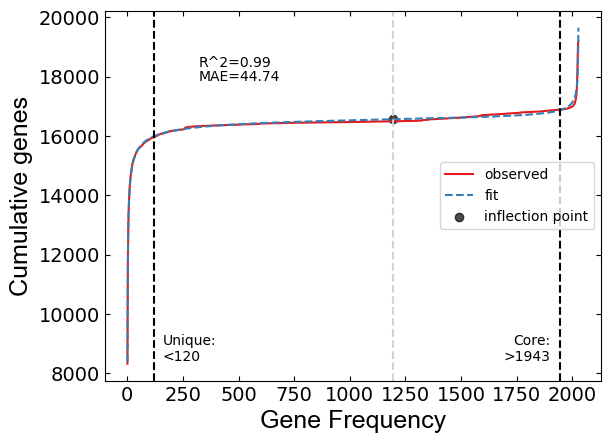

In [24]:
fig, ax = plt.subplots()
pg_curves = find_pangenome_segments(df_genes, ax=ax)
ax.set_ylabel('Cumulative genes', fontname='Arial', fontsize=18)
ax.set_xlabel('Gene Frequency', fontname='Arial', fontsize=18)
ax.tick_params(which='both', axis='both', direction='in', reset=True)
ax.set_xticklabels(np.arange(-250, 2250, 250), fontsize=14)
ax.set_yticklabels(np.arange(6000, 22000, 2000), fontsize=14)
plt.legend(loc=5)
plt.savefig('figures/Pangenome_unique_core_cutoff.svg')

/home/saugat/anaconda3/envs/rnseq/lib/python3.7/site-packages/ipykernel_launcher.py:274: RuntimeWarning: overflow encountered in exp
/home/saugat/anaconda3/envs/rnseq/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/saugat/anaconda3/envs/rnseq/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


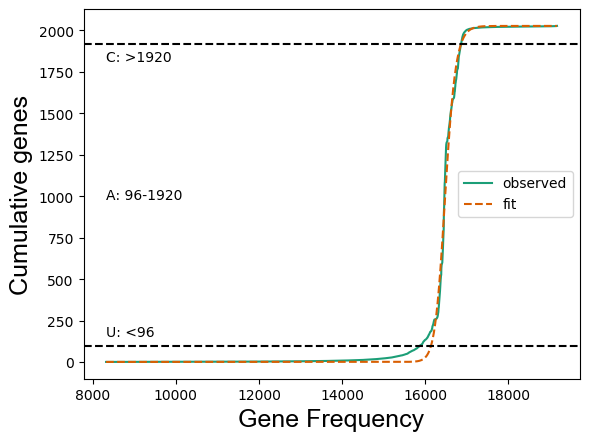

In [14]:
fig, ax = plt.subplots()
pg_curves = find_pangenome_segments(df_genes, ax=ax)
ax.set_ylabel('Cumulative genes', fontname='Arial', fontsize=18)
ax.set_xlabel('Gene Frequency', fontname='Arial', fontsize=18)

plt.savefig('')
plt.legend()

In [109]:
gene_freq = df_genes.fillna(0).sum(axis=1)

In [118]:
ccount = len(gene_freq[gene_freq > 1943])
acount = len(gene_freq[gene_freq < 120])
print ("Total genes:", len(gene_freq))
print("Number of core genes:", ccount)
print("Number of unique genes:",  acount)
print("Number of accessory genes:",  len(gene_freq) - ccount - acount)

Total genes: 19176
Number of core genes: 2291
Number of unique genes: 15954
Number of accessory genes: 931
